# MIMO TDM

You can open this workbook in Google Colab to experiment with mmWrt 
[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/MIMO_TDM.ipynb)

Below is an intro to mmWrt for simple targets position in (X,Y) plane based on 2D FFT (Range, Azimuth) FFTs with a TDM MIMO.

## TDM MIMO ULA

## Setup

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
from os.path import abspath, basename, join, pardir
import datetime

# hack to handle if running from git cloned folder or stand alone (like Google Colab)
cw = basename(abspath(join(".")))
dp = abspath(join(".",pardir))
if cw=="docs" and basename(dp) == "mmWrt":
    # running from cloned folder
    print("running from git folder, using local path (latest) mmWrt code", dp)
    sys.path.insert(0, dp)
else:
    print("running standalone, need to ensure mmWrt is installed")
    !{sys.executable} -m pip install mmWrt

from os.path import abspath, join, pardir
import sys
from numpy.fft import fft, fftshift
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from numpy import arange, cos, sin, pi, zeros

from mmWrt.Scene import Antenna, Medium, Radar, Receiver, Target, Transmitter
from mmWrt.Raytracing import rt_points
from mmWrt import __version__
print("version:", __version__)

print(datetime.datetime.now())

running from git folder, using local path (latest) mmWrt code c:\git\mmWrt
version: 0.0.9-pre.1
2024-11-01 16:29:16.938342


['x0:10.1, y0:0.0, z0:0', 'x0:1.2307700331430901e-15, y0:20.1, z0:0', 'x0:-30.08514746700852, y0:0.94546384825166, z0:0']


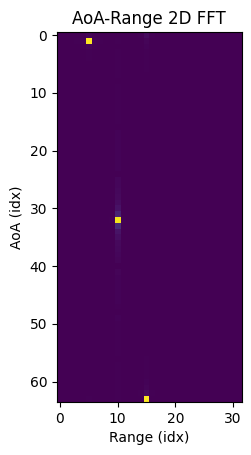

In [2]:
f0 = 62e9
# Number of ADC samples
NA = 64
# Number of TX channels
NT = 8
# Number of RX channels
NR = 8

void = Medium()
c = void.v
lambda0 = c/f0
_fs = 6e3
_k = 70e8
TXs = [Antenna(x=NR*lambda0/2*i) for i in range(NT)]
RXs = [Antenna(x=lambda0/2*i) for i in range(NR)]

radar = Radar(transmitter=Transmitter(bw=3.5e9, slope=_k,
                                      antennas=TXs),
              receiver=Receiver(fs=_fs, max_adc_buffer_size=2048,
                                n_adc=NA,
                                antennas=RXs),
              debug=False)
r1, theta1 = 10.1, 0
x1, y1 = r1*cos(theta1), r1*sin(theta1)
r2, theta2 = 20.1, pi/2
x2, y2 = r2*cos(theta2), r2*sin(theta2)
r3, theta3 = 30.1, pi*0.99
x3, y3 = r3*cos(theta3), r3*sin(theta3)

target1 = Target(x1, y1, 0)  # 0 degrees on x-axis <=> -pi/2 vs bore sight
target2 = Target(x2, y2, 0) # pi/2 degrees vs x-ax <=> 0 degree vs bore sight
target3 = Target(x3, y3, 0) # 180 degrees on x-axis <=> pi/2 vs boresight
targets = [target1, target2, target3]
print([f"{t}" for t in targets])
bb = rt_points(radar, targets,
               debug=False)
cube = bb["adc_cube"]
# bb[frame_i, chirp_i, tx_i, rx_i, adc_i]

# generate virtual antennas
virtual_cube = zeros(( NT * NR, NA))

for tx_idx in range(NT):
    for rx_idx in range(NR):
        virtual_cube[tx_idx*NT+ rx_idx,:] = cube[:, :, tx_idx, rx_idx, :]

fast_time_axis = 1
RX_antennas_axis = 0
# first compute the range FFT
R_fft = fft(virtual_cube, axis=fast_time_axis)
# then compute the AoA FFT
A_FFT = fft(R_fft, axis=RX_antennas_axis)

# for Range vs AoA, display magnitude
# and need to fftshift to have the negative frequencies moved around 0
Z_fft = abs(fftshift(A_FFT[:,:], axes=0))
plt.xlabel("Range (idx)")
plt.ylabel("AoA (idx)")
plt.title('AoA-Range 2D FFT')
plt.imshow(Z_fft[:,:NA//2])

## ULA in elevation

! BW ADC: 7.5e+07 << chirp: 3.5e+09
Bandwidth in chirp: 3.5e+09
Bandwidth in ADC buffers: 7.5e+07
rx fmin 60.0
rx fmax 63.5
tx fmin 60.0
tx fmax 63.5
['x0:0.0, y0:0.0, z0:10.1', 'x0:1.2307700331430901e-15, y0:20.1, z0:1.2307700331430901e-15', 'x0:5.789296377354671e-17, y0:0.94546384825166, z0:-30.08514746700852']
??1 (49, 64)


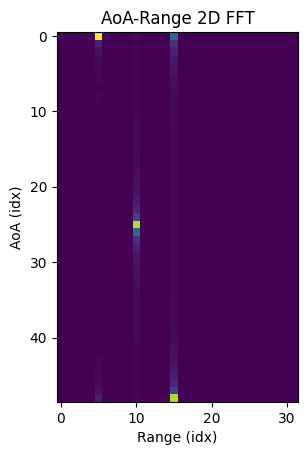

In [3]:
## ULA in elevation
NT = 7
# Number of RX channels
NR = 7

# Now define target1 with an elevation:
r1, theta1, phi1 = 10.1, pi/2, pi*0.0
x1 = r1 * cos(theta1)*sin(phi1)
y1 = r1 * sin(theta1)*sin(phi1)
z1 = r1 * cos(phi1)

r2, theta2, phi2 = 20.1, pi/2, pi/2
x2 = r2 * sin(phi2)*cos(theta2)
y2 = r2 * sin(phi2)*sin(theta2)
z2 = r2 * cos(phi2)

r3, theta3, phi3 = 30.1, pi/2, pi*0.99
x3 = r3 * sin(phi3)*cos(theta3)
y3 = r3 * sin(phi3)*sin(theta3)
z3 = r3 * cos(phi3)
target1 = Target(x1, y1, z1)  # 0 degrees on x-axis <=> -pi/2 vs bore sight
target2 = Target(x2, y2, z2) # pi/2 degrees vs x-ax <=> 0 degree vs bore sight
target3 = Target(x3, y3, z3) # 180 degrees on x-axis <=> pi/2 vs boresight

# offset so that middle antenna is at 0,0,0
TXs = [Antenna(y=NR*lambda0/2*i - (NR*lambda0/2)) for i in range(NT)]
RXs = [Antenna(y=lambda0/2*i - ((NR-1)//2)*lambda0/2) for i in range(NR)]

radar = Radar(transmitter=Transmitter(bw=3.5e9, slope=_k,
                                      antennas=TXs),
              receiver=Receiver(fs=_fs, max_adc_buffer_size=2048,
                                n_adc=NA,
                                antennas=RXs),
              debug=True)
targets = [target1, target2, target3]
print([f"{t}" for t in targets])
bb = rt_points(radar, targets,
               debug=False)
cube = bb["adc_cube"]

# generate virtual antennas
virtual_cube = zeros(( NT * NR, NA))
print("??1", virtual_cube.shape)
for tx_idx in range(NT):
    for rx_idx in range(NR):
        virtual_cube[tx_idx*NT+ rx_idx,:] = cube[:, :, tx_idx, rx_idx, :]

RX_antennas_axis = 0
fast_time_axis = 1
# first compute the range FFT
R_fft = fft(virtual_cube, axis=fast_time_axis)
# then compute the AoA FFT
A_FFT = fft(R_fft, axis=RX_antennas_axis)

# for Range vs AoA, display magnitude
# and need to fftshift to have the negative frequencies moved around 0
Z_fft = abs((A_FFT[:,:]))
plt.xlabel("Range (idx)")
plt.ylabel("AoA (idx)")
plt.title('AoA-Range 2D FFT')
plt.imshow(Z_fft[:,:NA//2])

## URA

We are now considering the case where the targets have an elevation (i.e. a `z` dimension not null).

(r, $\theta$, $\phi$) are defined as per polar coordinates:

![](https://cdn1.byjus.com/wp-content/uploads/2019/09/Spherical-coordinate-system.png)

* $ x = r * \sin(\phi) \cdot \cos(\theta) $
* $ y = r * \sin(\phi) \cdot \sin(\theta) $
* $ z = r * \cos(\phi) $

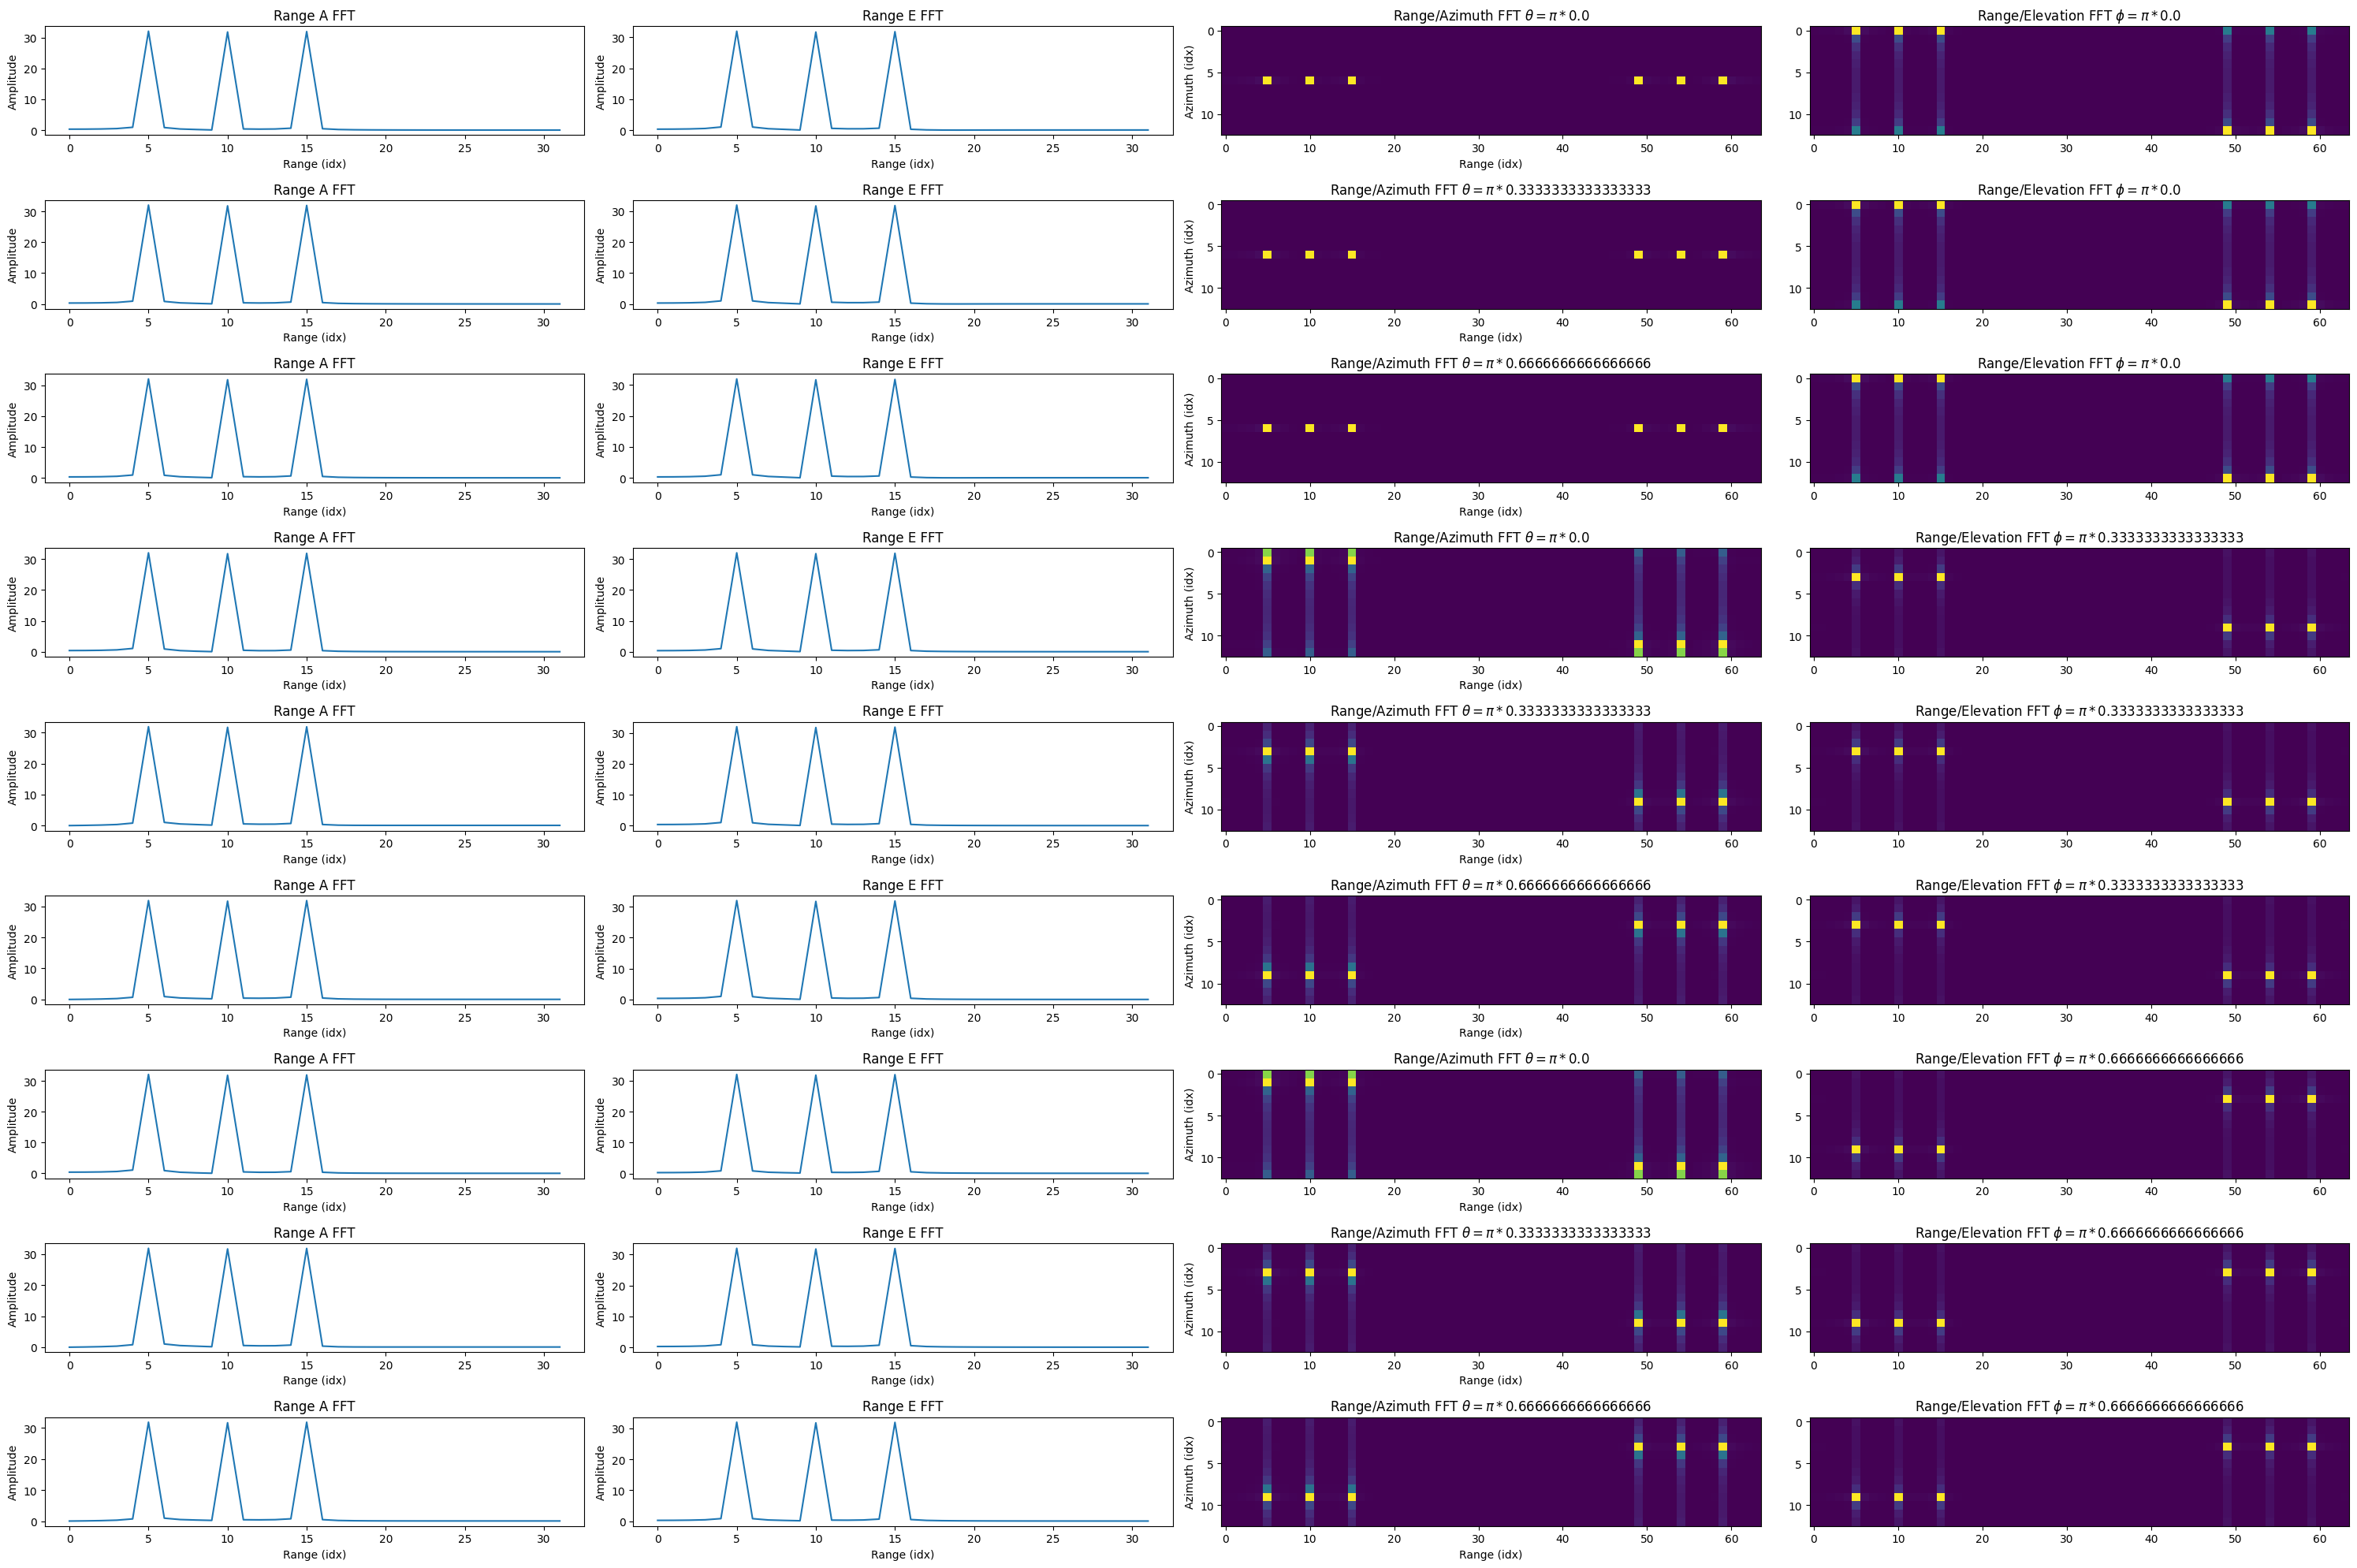

In [39]:
# first redefine the TX antennas: 
# instead of TX being NR*lambda0/2 apart on the x-axis to have a ULA,
# we define them lambda0/2 on the y-axis to have a URA
NT = 13
NR = 13
TXs = [Antenna(z=lambda0/2*i - ((NT-1)//2)*lambda0/2) for i in range(NT)]
RXs = [Antenna(x=lambda0/2*i - ((NR-1)//2)*lambda0/2) for i in range(NR)]
# then update the radar definition
radar = Radar(transmitter=Transmitter(bw=3.5e9, slope=_k,
                                      antennas=TXs),
              receiver=Receiver(fs=_fs, max_adc_buffer_size=2048,
                                n_adc=NA,
                                antennas=RXs),
              debug=False)

# Now define target1 with an elevation:
theta, phi = pi*0.0, pi*1.0
theta_steps = 3
phi_steps = 3
fig, axs = plt.subplots(ncols=4, nrows=theta_steps*phi_steps, figsize=(30,20))

for phi_idx in range(phi_steps):
    for theta_idx in range(theta_steps):
        theta0, phi0 = theta_idx/theta_steps, phi_idx/phi_steps
        theta, phi = theta0*pi, phi0*pi
        r1, theta1, phi1 = 10.1, theta, phi
        x1 = r1 * cos(theta1)*sin(phi1)
        y1 = r1 * sin(theta1)*sin(phi1)
        z1 = r1 * cos(phi1)
        r2, theta2, phi2 = 20.1, theta, phi
        x2 = r2 * cos(theta2)*sin(phi2)
        y2 = r2 * sin(theta2)*sin(phi2)
        z2 = r2 * cos(phi2)
        r3, theta3, phi3 = 30.1, theta, phi
        x3 = r3 * sin(phi3)*cos(theta3)
        y3 = r3 * sin(phi3)*sin(theta3)
        z3 = r3 * cos(phi3)
        target1 = Target(x1, y1, z1)
        target2 = Target(x2, y2, z2)
        target3 = Target(x3, y3, z3)
        targets = [target1, target2, target3]
    
        bb = rt_points(radar, targets, debug=False)
        cube = bb["adc_cube"]
    
        # define virtual cubes
        virtual_cube_azimuth = zeros(( NR, NA)).astype(complex)
        virtual_cube_elevation = zeros(( NT , NA)).astype(complex)
        for rx_idx in range(NR):
            virtual_cube_azimuth[rx_idx,:] = cube[0, 0, (NT-1)//2, rx_idx, :]
        for tx_idx in range(NT):
            virtual_cube_elevation[tx_idx,:] = cube[0, 0, tx_idx, (NR-1)//2, :]
    
        # compute (just to show this is the same
        # Range FFT from Azi and Ele cubes
        RF1 = fft(virtual_cube_azimuth, axis=-1)
        RF2 = fft(virtual_cube_elevation, axis=-1)
    
        # Range Azimuth cube
        RA = fftshift(fft(RF1, axis=0), axes=0)
        # Range Elevation cube
        RE = fftshift(fft(RF2, axis=0), axes=0)
        
        ax0, ax1, ax2, ax3 = axs[theta_idx+(theta_steps)*phi_idx, 0], axs[theta_idx+(theta_steps)*phi_idx, 1], \
            axs[theta_idx+(theta_steps)*phi_idx,2],axs[theta_idx+(theta_steps)*phi_idx, 3]
    
        # show Range FFT from Azi FFT
        ax0.set_xlabel("Range (idx)")
        ax0.set_ylabel("Amplitude")
        ax0.set_title('Range A FFT')
        ax0.plot(abs(RF1[0,:NA//2]))
    
        # show Range FFT from Ele FFT
        ax1.set_xlabel("Range (idx)")
        ax1.set_ylabel("Amplitude")
        ax1.set_title('Range E FFT')
        ax1.plot(abs(RF2[0,:NA//2]))
    
        # Show Range Azi map
        ax2.set_xlabel("Range (idx)")
        ax2.set_ylabel("Azimuth (idx)")
        ax2.set_title(fr'Range/Azimuth FFT $\theta = \pi *{theta0}$')
        # use interpolation and aspect to have the map same size as Range FFT
        ax2.imshow(abs(RA), interpolation='nearest', aspect='auto')
    
        # Show Range Ele map
        ax3.set_title(f"Range/Elevation FFT $\phi= \pi *{phi0}$")
        # use interpolation and aspect to have the map same size as Range FFT
        ax3.imshow(abs(RE),interpolation='nearest', aspect='auto')
plt.tight_layout()
